# Package/Data Import

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings('ignore')

In [2]:
train  = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

In [3]:
train = train.drop(['index','country'], axis = 1)

# Preprocessing

## 이상치 제거

In [4]:
# 이상치 제거 함수
def remove_outlier_test(data, column, k):
    data_column = data[column]
    Q_25 = np.percentile(data_column, 25)
    Q_75 = np.percentile(data_column, 75)
    
    IQR = Q_75 - Q_25
    IQR = k*IQR
    lowest = Q_25 - IQR
    highest = Q_75 + IQR
    out_index = data_column[(data_column < lowest)|(data_column > highest)].index
    print(len(out_index))
    return(out_index)

In [5]:
#age 이상치 drop하기
out_index = remove_outlier_test(train, 'age', 6)

train = train.drop(out_index)

9


In [6]:
out_index2 = remove_outlier_test(train, 'familysize', 6)

0


In [7]:
remove_outlier_test(train, 'familysize', 1.5)

0


Int64Index([], dtype='int64')

In [8]:
# 시간 제거
index3 = train[train['testelapse'] < 42].index
train = train.drop(index3)

In [9]:
Y = train['nerdiness']
train = train.drop('nerdiness', axis = 1)

## 파생변수 생성

### VCL 관련 파생변수

In [10]:
train['VCL_sum'] = train['VCL1']+train['VCL2']+train['VCL3']+train['VCL4']+train['VCL5']+train['VCL7']+train['VCL8']+train['VCL10']+train['VCL11']+train['VCL13']+train['VCL14']+train['VCL15']+train['VCL16']
train['VCL_sum2'] = train['VCL_sum'] + 3 - train['VCL6']-train['VCL9']-train['VCL12']
train['VCL_vaild'] = 3 - train['VCL6']-train['VCL9']-train['VCL12']

train['VCL_hard'] = train['VCL3']+train['VCL7']+train['VCL8']+train['VCL11']+train['VCL13']+ 3 - train['VCL6']-train['VCL9']-train['VCL12']
train['VCL_easy'] = train['VCL1']+train['VCL2']+train['VCL4']+train['VCL5']+train['VCL10']+train['VCL14']+train['VCL15']+train['VCL16']

In [11]:
test['VCL_sum'] = test['VCL1']+test['VCL2']+test['VCL3']+test['VCL4']+test['VCL5']+test['VCL7']+test['VCL8']+test['VCL10']+test['VCL11']+test['VCL13']+test['VCL14']+test['VCL15']+test['VCL16']
test['VCL_sum2'] = test['VCL_sum'] + 3 - test['VCL6']-test['VCL9']-test['VCL12']
test['VCL_vaild'] = 3 - test['VCL6']-test['VCL9']-test['VCL12']

test['VCL_hard'] = test['VCL3']+test['VCL7']+test['VCL8']+test['VCL11']+test['VCL13']+ 3 - test['VCL6']-test['VCL9']-test['VCL12']
test['VCL_easy'] = test['VCL1']+test['VCL2']+test['VCL4']+test['VCL5']+test['VCL10']+test['VCL14']+test['VCL15']+test['VCL16']

### TIPI 관련 파생변수

In [12]:
train['extraversion']= (train['TIPI1']+ (6-train['TIPI6']))/2 
train['agreeableness']= (train['TIPI7']+ (6-train['TIPI2']))/2 
train['conscientiousness']= (train['TIPI3']+ (6-train['TIPI8']))/2 
train['emotionalstability']= (train['TIPI9']+ (6-train['TIPI4']))/2 
train['openess']= (train['TIPI5']+ (6-train['TIPI10']))/2 

In [13]:
test['extraversion']= (test['TIPI1']+ (6-test['TIPI6']))/2 
test['agreeableness']= (test['TIPI7']+ (6-test['TIPI2']))/2 
test['conscientiousness']= (test['TIPI3']+ (6-test['TIPI8']))/2 
test['emotionalstability']= (test['TIPI9']+ (6-test['TIPI4']))/2 
test['openess']= (test['TIPI5']+ (6-test['TIPI10']))/2 

In [14]:
def low(x,y):
    if x <= y:
        return 1
    else:
        return 0


train['lowextra'] = train.extraversion.apply(lambda x: low(x,2.4))
train['lowagree'] = train.agreeableness.apply(lambda x: low(x,3.5))
train['lowopen'] = train.openess.apply(lambda x: low(x,4.4))
train['lowstab'] = train.emotionalstability.apply(lambda x: low(x,2.9))
train['lowconsci'] = train.conscientiousness.apply(lambda x: low(x,3.2))

In [15]:
test['lowextra'] = test.extraversion.apply(lambda x: low(x,2.4))
test['lowagree'] = test.agreeableness.apply(lambda x: low(x,3.5))
test['lowopen'] = test.openess.apply(lambda x: low(x,4.4))
test['lowstab'] = test.emotionalstability.apply(lambda x: low(x,2.9))
test['lowconsci'] = test.conscientiousness.apply(lambda x: low(x,3.2))

* extraversion ~ openess 변수들이 평균 미만인 경우 1, 아닌 경우 0 을 가지는 low 변수 생성
* 평균값은 인터넷자료를 참고해 임의의 값으로 설정(2.4, 3.5, 4.4, 2.9, 3.2)

### Q 관련 파생변수
- 마키아벨리즘 테스트 스코어를 파생변수로 생성

In [16]:
Q_Ques=train[['Q1', 'Q2', 'Q3', 'Q4', 'Q5','Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 
             'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26']]

Q_Score=Q_Ques.sum(axis=1)
train['Q_Score']=Q_Score
train

Q_Ques=test[['Q1', 'Q2', 'Q3', 'Q4', 'Q5','Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 
             'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26']]

Q_Score=Q_Ques.sum(axis=1)
test['Q_Score']=Q_Score
test

,index,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,agreeableness,conscientiousness,emotionalstability,openess,lowextra,lowagree,lowopen,lowstab,lowconsci,Q_Score
0,0,4.0,4.0,3.0,5.0,5.0,5.0,3.0,5.0,4.0,...,2.5,3.0,2.5,4.0,1,1,1,1,1,109.0
1,1,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,...,2.5,3.0,2.0,4.5,1,1,0,1,1,112.0
2,2,5.0,5.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,...,4.0,3.5,2.5,4.5,0,0,0,1,0,109.0
3,3,5.0,4.0,3.0,4.0,5.0,4.0,5.0,4.0,4.0,...,3.0,2.5,3.0,4.5,1,1,0,0,1,98.0
4,4,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,...,3.0,2.5,2.0,3.5,0,1,1,1,1,106.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35447,35447,4.0,5.0,5.0,3.0,3.0,4.0,5.0,5.0,4.0,...,3.0,4.0,2.0,5.0,0,1,0,1,0,108.0
35448,35448,5.0,5.0,5.0,5.0,5.0,4.0,5.0,3.0,5.0,...,4.0,4.0,1.0,3.5,1,0,1,1,0,115.0
35449,35449,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,2.0,2.5,2.5,4.5,1,1,0,1,1,119.0
35450,35450,5.0,5.0,4.0,5.0,5.0,1.0,5.0,1.0,5.0,...,3.0,5.0,5.0,5.0,1,1,0,0,0,104.0


## 표준화 및 결측치 처리

### 표준화

In [17]:
# Standardization 평균 0 / 분산 1
scaler = StandardScaler()   

transformed_train = scaler.fit_transform(train)

transformed_train

array([[-2.71370371,  0.79951809,  0.75973879, ..., -0.81361074,
        -1.09237515, -0.0565871 ],
       [ 0.0249671 , -0.05546786, -0.21788315, ...,  1.22908898,
        -1.09237515, -0.71158032],
       [ 0.0249671 ,  0.79951809,  0.75973879, ..., -0.81361074,
         0.91543642,  0.00891222],
       ...,
       [ 0.0249671 ,  0.79951809,  0.75973879, ...,  1.22908898,
         0.91543642,  1.58089595],
       [ 0.93785737,  0.79951809, -0.21788315, ...,  1.22908898,
         0.91543642,  0.72940476],
       [ 0.93785737, -0.05546786, -2.17312702, ..., -0.81361074,
         0.91543642, -0.44958304]])

In [18]:
train = pd.DataFrame(transformed_train, columns = train.columns)

In [19]:
test = test.drop(['country','index'], axis = 1)
transformed_test = scaler.transform(test)

In [20]:
test = pd.DataFrame(transformed_test, columns = test.columns)

### KNN Imputer를 이용해 결측치 대체
- 학습데이터를 이용해 학습된 knn imputer를 이용해 결측치 대체

In [21]:
imputer = KNNImputer(n_neighbors = 3)
imputed = imputer.fit_transform(train)

In [22]:
imputed

array([[-2.71370371,  0.79951809,  0.75973879, ..., -0.81361074,
        -1.09237515, -0.0565871 ],
       [ 0.0249671 , -0.05546786, -0.21788315, ...,  1.22908898,
        -1.09237515, -0.71158032],
       [ 0.0249671 ,  0.79951809,  0.75973879, ..., -0.81361074,
         0.91543642,  0.00891222],
       ...,
       [ 0.0249671 ,  0.79951809,  0.75973879, ...,  1.22908898,
         0.91543642,  1.58089595],
       [ 0.93785737,  0.79951809, -0.21788315, ...,  1.22908898,
         0.91543642,  0.72940476],
       [ 0.93785737, -0.05546786, -2.17312702, ..., -0.81361074,
         0.91543642, -0.44958304]])

In [23]:
train = pd.DataFrame(imputed, columns = train.columns)

In [24]:
test

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,agreeableness,conscientiousness,emotionalstability,openess,lowextra,lowagree,lowopen,lowstab,lowconsci,Q_Score
0,0.024967,-0.055468,-1.195505,0.988232,0.957351,1.131945,-1.116786,0.861430,0.076864,0.849490,...,-0.896785,-0.234745,-0.445590,0.195794,1.133932,0.614963,0.699744,1.229089,0.915436,0.860403
1,0.024967,0.799518,-0.217883,0.168578,0.957351,0.277903,0.771013,0.861430,0.971788,-0.105665,...,-0.896785,-0.234745,-0.948099,0.844210,1.133932,0.614963,-1.429094,1.229089,0.915436,1.056901
2,0.937857,0.799518,0.759739,0.988232,0.120916,1.131945,0.771013,0.861430,0.971788,-0.105665,...,0.904817,0.314928,-0.445590,0.844210,-0.881887,-1.626115,-1.429094,1.229089,-1.092375,0.860403
3,0.937857,-0.055468,-1.195505,0.168578,0.957351,0.277903,0.771013,0.093569,0.076864,0.849490,...,-0.296251,-0.784419,0.056918,0.844210,1.133932,0.614963,-1.429094,-0.813611,0.915436,0.139911
4,0.937857,0.799518,0.759739,0.988232,0.957351,-0.576139,0.771013,0.861430,0.971788,0.849490,...,-0.296251,-0.784419,-0.948099,-0.452621,-0.881887,0.614963,0.699744,1.229089,0.915436,0.663905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35447,0.024967,0.799518,0.759739,-0.651077,-0.715519,0.277903,0.771013,0.861430,0.076864,-1.060821,...,-0.296251,0.864602,-0.948099,1.492626,-0.881887,0.614963,-1.429094,1.229089,-1.092375,0.794904
35448,0.937857,0.799518,0.759739,0.988232,0.957351,0.277903,0.771013,-0.674292,0.971788,-1.060821,...,0.904817,0.864602,-1.953116,-0.452621,1.133932,-1.626115,0.699744,1.229089,-1.092375,1.253399
35449,0.937857,0.799518,0.759739,0.988232,0.957351,1.131945,0.771013,0.861430,0.971788,0.849490,...,-1.497319,-0.784419,-0.445590,0.844210,1.133932,0.614963,-1.429094,1.229089,0.915436,1.515397
35450,0.937857,0.799518,-0.217883,0.988232,0.957351,-2.284223,0.771013,-2.210014,0.971788,0.849490,...,-0.296251,1.963948,2.066953,1.492626,1.133932,0.614963,-1.429094,-0.813611,-1.092375,0.532907


In [25]:
imputed_test = imputer.transform(test)

In [26]:
test = pd.DataFrame(imputed_test, columns = test.columns)

# Modeling - Random Forest

전체 변수를 모두 넣고 Random Forest를 학습한 후, feature importance를 확인해본 결과, VCL변수와 low*** 변수의 feature importance가 낮게 나와 이를 제거하고 모델링함
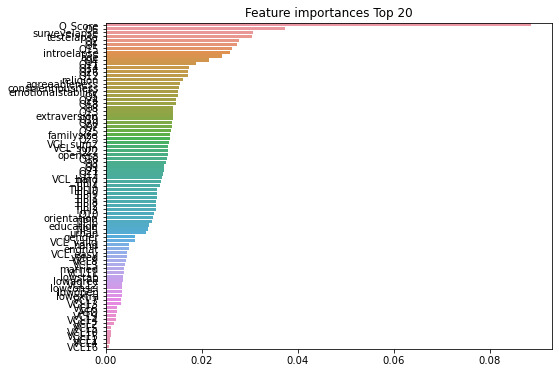

In [27]:
train = train.drop(['VCL1','VCL2','VCL3','VCL4','VCL5','VCL6','VCL7','VCL8','VCL9','VCL10','VCL11','VCL12','VCL13','VCL14','VCL15','VCL16','lowconsci','lowstab','lowagree','lowextra','lowopen'],axis = 1)

In [28]:
test = test.drop(['VCL1','VCL2','VCL3','VCL4','VCL5','VCL6','VCL7','VCL8','VCL9','VCL10','VCL11','VCL12','VCL13','VCL14','VCL15','VCL16','lowconsci','lowstab','lowagree','lowextra','lowopen'],axis = 1)

In [29]:
rf_clf = RandomForestClassifier(random_state = 0)
rf_clf.fit(train, Y)
pred = rf_clf.predict_proba(test)

In [30]:
submission = pd.read_csv('sample_submission.csv')

submission

,index,nerdiness
0,0,-1
1,1,-1
2,2,-1
3,3,-1
4,4,-1
...,...,...
35447,35447,-1
35448,35448,-1
35449,35449,-1
35450,35450,-1


In [31]:
submission["nerdiness"] = pred[:,1]

In [32]:
submission.to_csv("baseline_knn_vcl_TIPI_Q_pred.csv", index = False)